In [1]:
%matplotlib widget

In [2]:
import os
import sys
import pickle

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors
from astropy.convolution import Gaussian2DKernel, convolve

import umap
from sklearn.decomposition import PCA

#plt.style.use("../bioAI.mplstyle")

sys.path.append("../src") if "../src" not in sys.path else None 

from Experiment import Experiment
from methods import filenames

In [3]:
def load_experiment(path, name):
    experiment = Experiment(name = name, base_path = path)
    experiment.setup()
    return experiment

def load_ratemaps(experiment):
    # load grid scores + ratemaps
    ratemaps = []
    kernel = Gaussian2DKernel(x_stddev=1)
    for env_i in range(len(experiment.environments)):
        with open(experiment.paths['ratemaps'] / f'env_{env_i}' / filenames(experiment.paths['ratemaps'] / f'env_{env_i}')[-1], "rb") as f:
            ratemaps.append(convolve(pickle.load(f), kernel.array[None]))
    ratemaps = np.concatenate(ratemaps)
    return ratemaps

def env_split(stats, n_envs, Ng=4096):
    # stack ratemaps by environment
    env_stat = []
    for env_i in range(n_envs):
        tmp = stats[Ng*env_i:Ng*(env_i+1)]
        env_stat.append(tmp)
    return np.array(env_stat)

In [4]:
def PCA_UMAP(states):
    """ Run PCA followed by UMAP on states; Similar to Gardner et al. (2022)
    
    states.shape = (Nsamples, Nfeatures)
    PCA down to 6 features/principal components 
    UMAP of PCA componenents to 3 features.
    
    Note: Gardner et al. use n_neighbors = 5000 (more than number of samples in our case...)
    """
    pca_fit = PCA(n_components = 6).fit(states)
    pca_result = pca_fit.transform(states)
    umap_fit = umap.UMAP(n_components = 3, min_dist = 0.8,  # Almost Gardner et al. params
                         n_neighbors = 1000, metric = "cosine", init = "spectral")
    umap_result = umap_fit.fit_transform(pca_result)
    return pca_result, umap_result

In [5]:
def scatter_3d(data, tags = None, title = "", axes = None):
    if axes is None:
        fig = plt.figure()
        ax = fig.add_subplot(projection='3d')
    else:
        ax = axes
    ax.set_title(title)
    norm = matplotlib.colors.Normalize(np.amin(tags), np.amax(tags))
    col = matplotlib.cm.viridis(norm(tags))
    ax.scatter(xs=data[:,0], ys=data[:,1], zs=data[:,2], c = col, s = 15, alpha = 0.7)
    ax.axis("off")
    
    if axes is None:
        return fig

In [6]:
# Load ratemaps and module indices
#base_path = "/home/users/vemundss/"
base_path = "/mnt/WD12TB-HDD"
experiment = load_experiment(base_path, "gg-3ME")
ratemaps = load_ratemaps(experiment)
module_indices = np.load(f"{experiment.paths['experiment']}/module_indices.npz")

Experiment <gg-3ME> already EXISTS. Loading experiment settings!
Loading experiment details
This experiment has ALREADY been setup - SKIPPING.


In [8]:
ratemaps = env_split(ratemaps, len(experiment.environments))

In [9]:
g = np.reshape(ratemaps, (*ratemaps.shape[:2],-1)) # flatten bin dims; (Nenv, Ng, nbins)
g = np.transpose(g, (0, 2, 1)) # reshape so cell dim is last


In [10]:
"""
1. Run through each environments
2. Perform PCA + UMAP for each cluster, in each environment
3. Plot result
"""

fig_titles = []
pca_fits = []
umap_fits = []

for i, key in enumerate(module_indices):

    current_module = module_indices[key]

    env_pca_fits = []
    env_umap_fits = []
    env_titles = []
    # run in each environment
    for j in range(len(ratemaps)): 
        pca_fit, umap_fit = PCA_UMAP(g[j][:, current_module])

        title = f"{key}_in_env{j}"
        env_titles.append(title)
        env_pca_fits.append(pca_fit)
        env_umap_fits.append(umap_fit)

    fig_titles.append(env_titles)
    pca_fits.append(env_pca_fits)
    umap_fits.append(env_umap_fits)

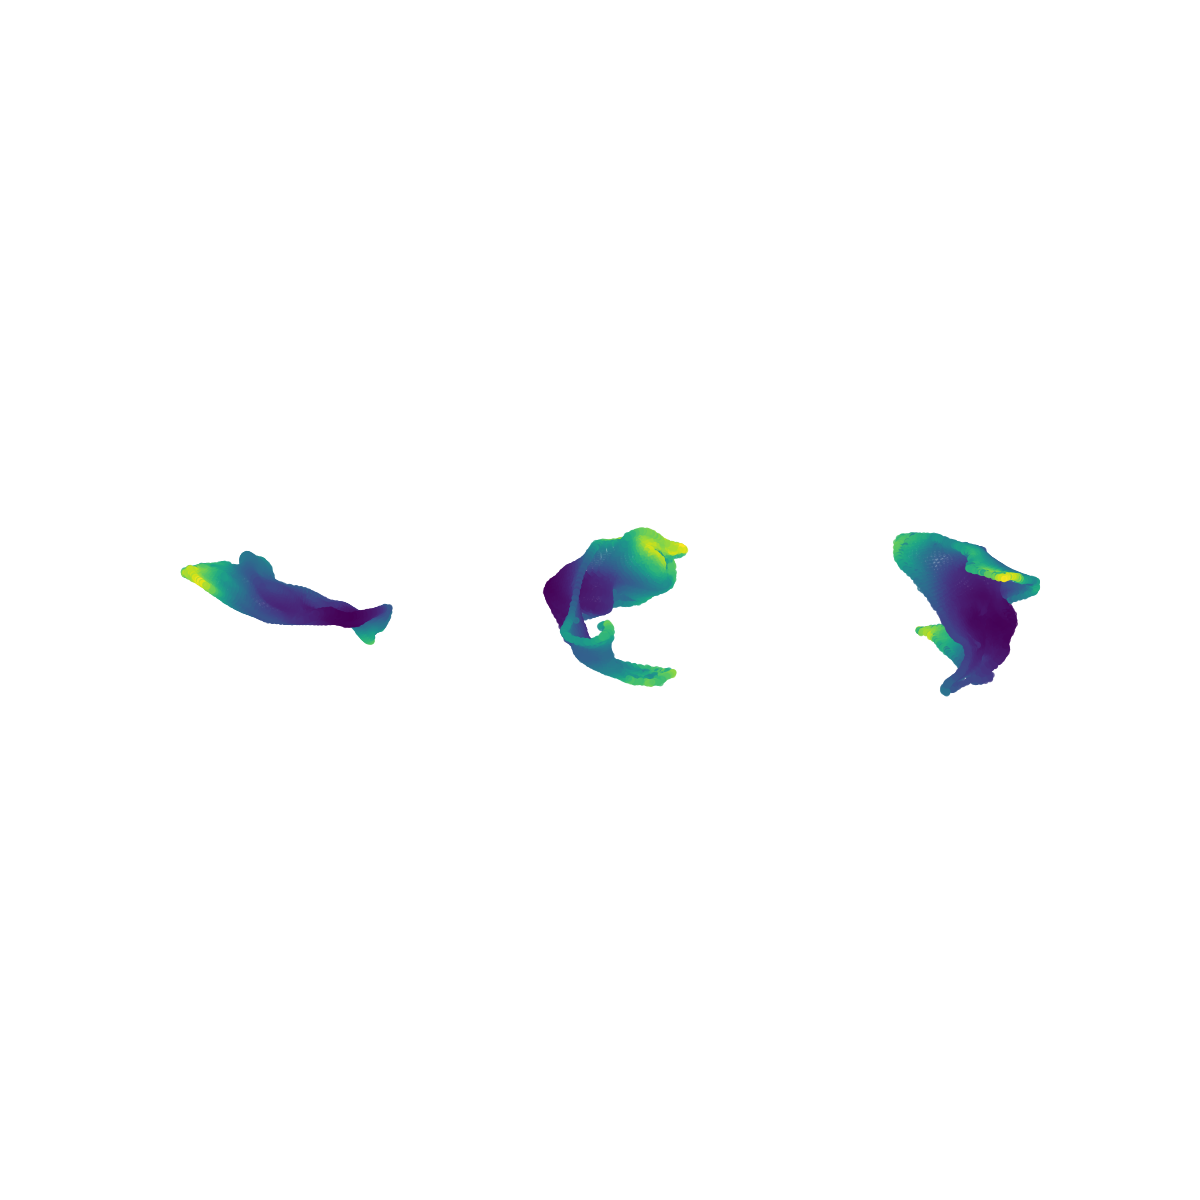

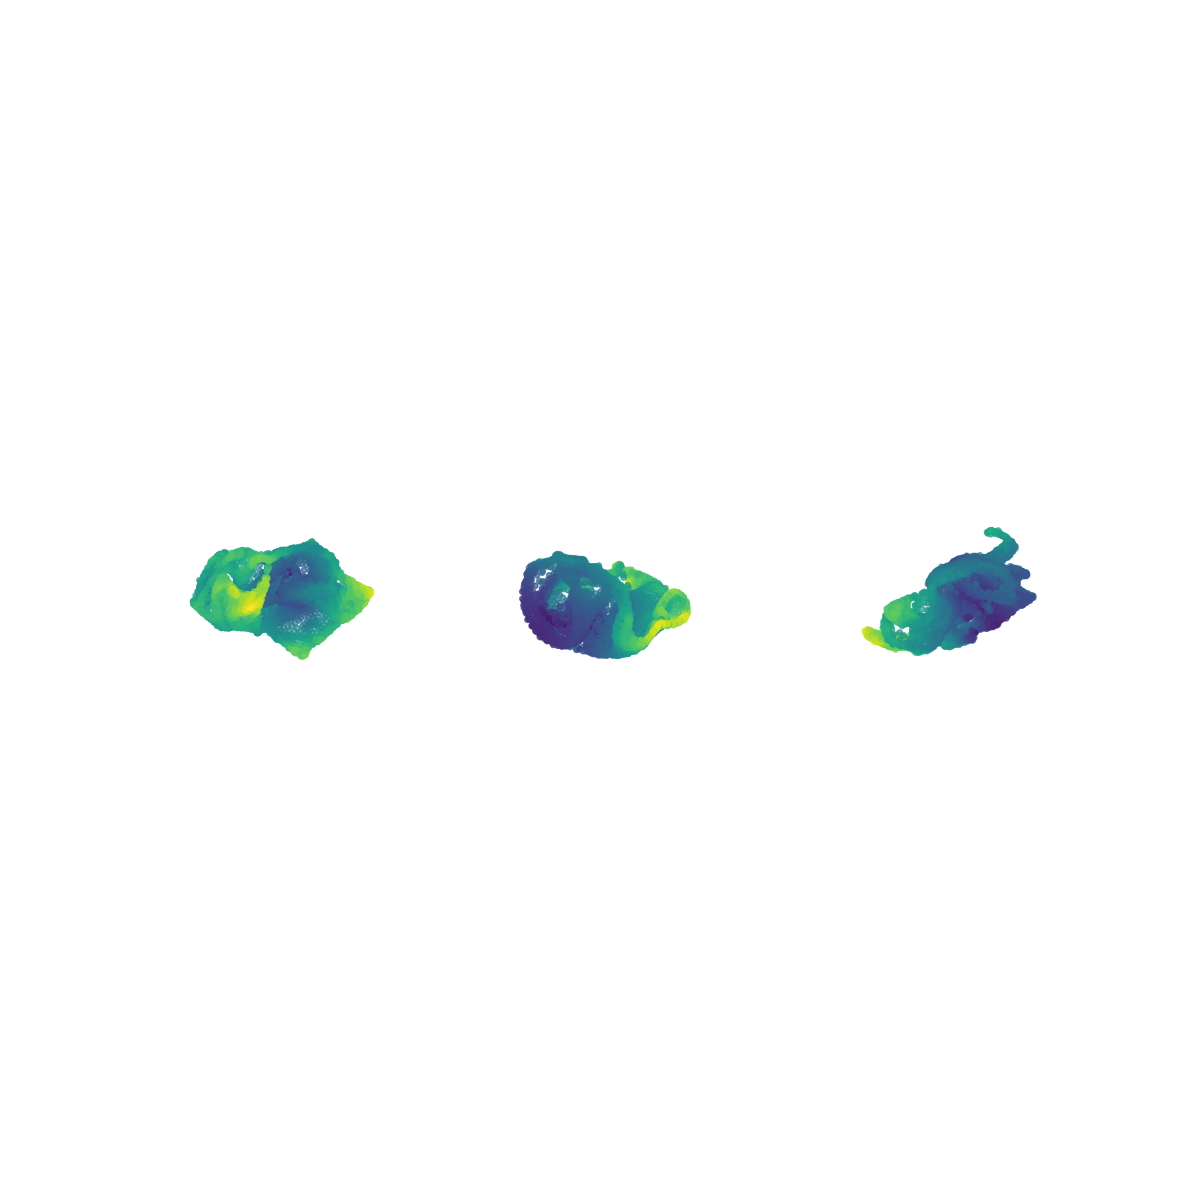

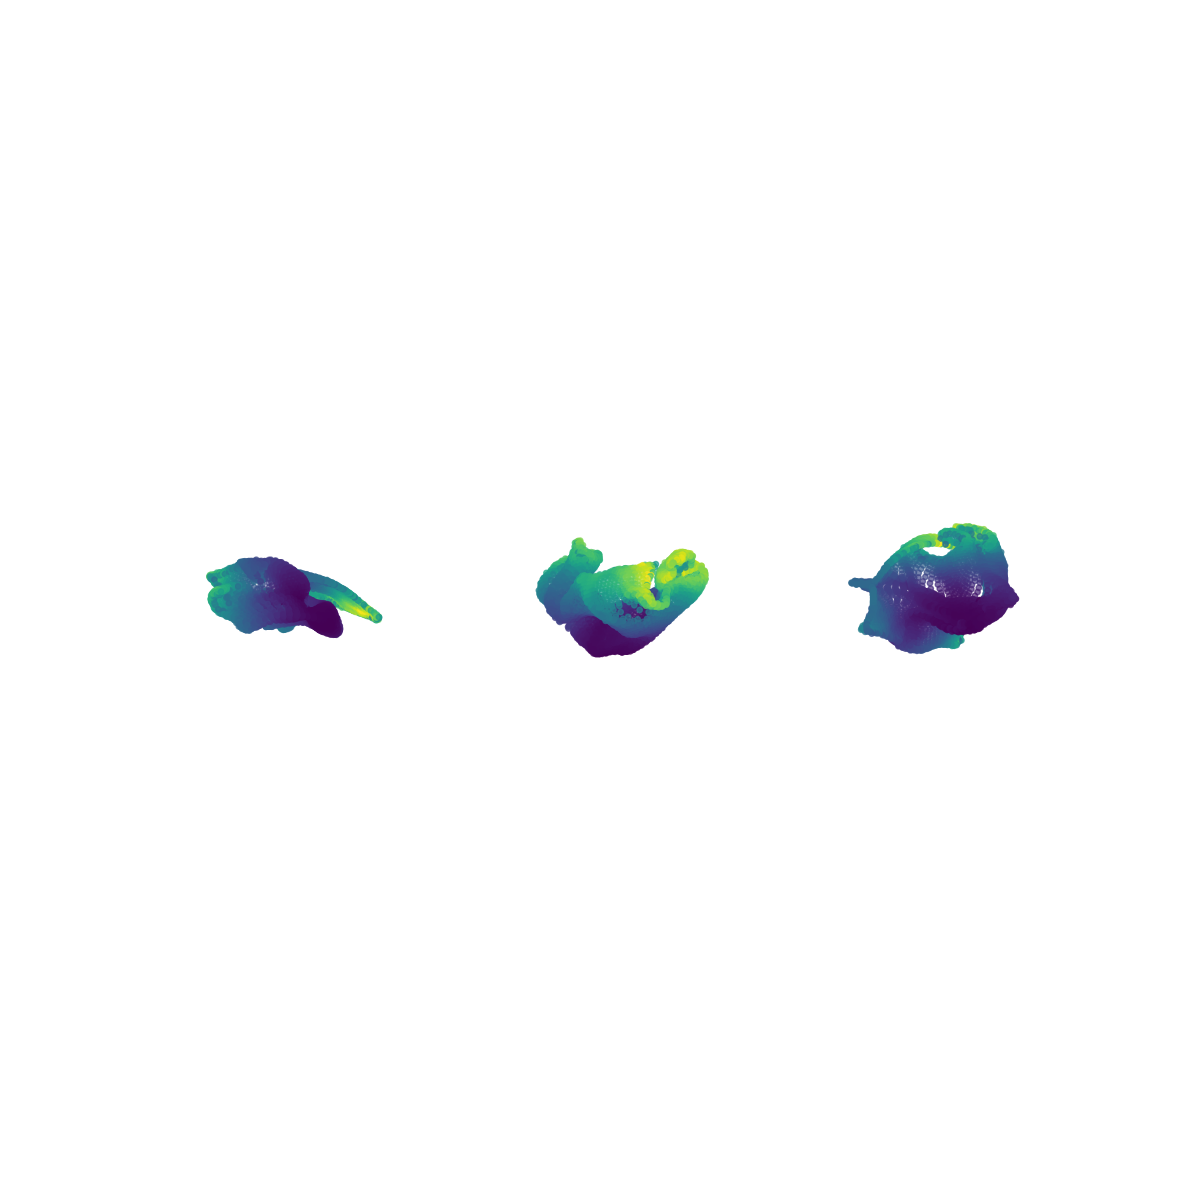

In [11]:
env_figs = []

figdims = np.array([len(module_indices), len(experiment.environments)])
figsize = 4*figdims

for u, pc, title in zip(umap_fits, pca_fits, fig_titles):
    fig = plt.figure(figsize = figsize)
    for i in range(len(ratemaps)):
        ax = fig.add_subplot(1, len(ratemaps), i+1, projection = "3d")
        scatter_3d(u[i], pc[i][:,0], axes = ax)
    env_figs.append(fig)